In [39]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from arff2pandas import a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
with open('ECG5000/ECG5000_TRAIN.arff') as f:
    train = a2p.load(f)

with open('ECG5000/ECG5000_TEST.arff') as f:
    test = a2p.load(f)

In [42]:
df = train.append(test)
df.shape

(5000, 141)

In [43]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [44]:
df["target"].value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

/opt/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


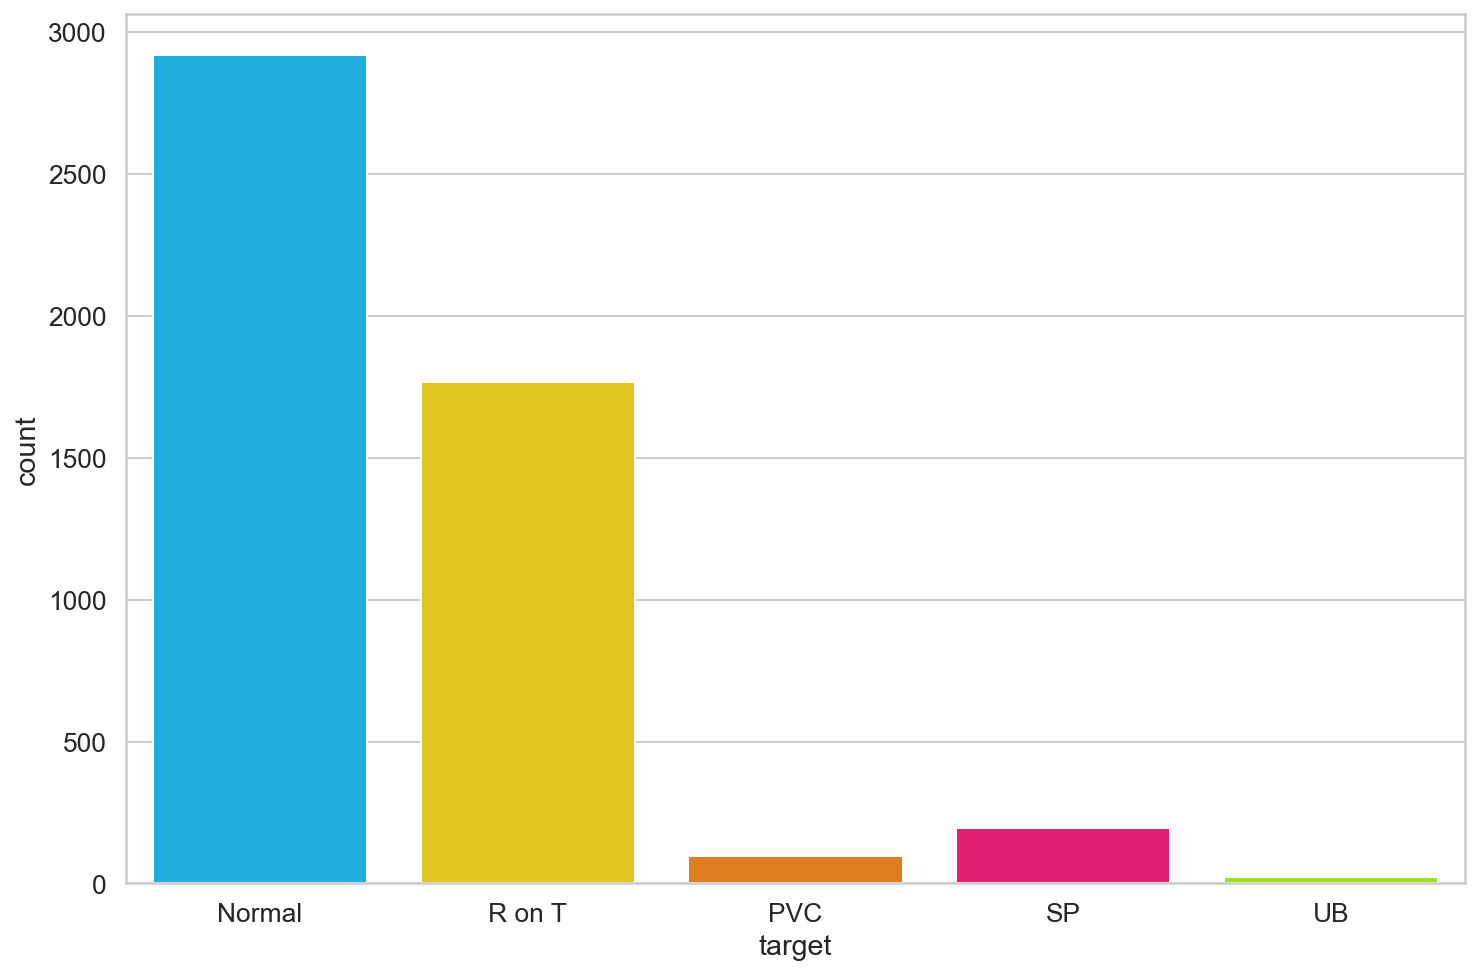

In [45]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

In [46]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
    )
    ax.set_title(class_name)

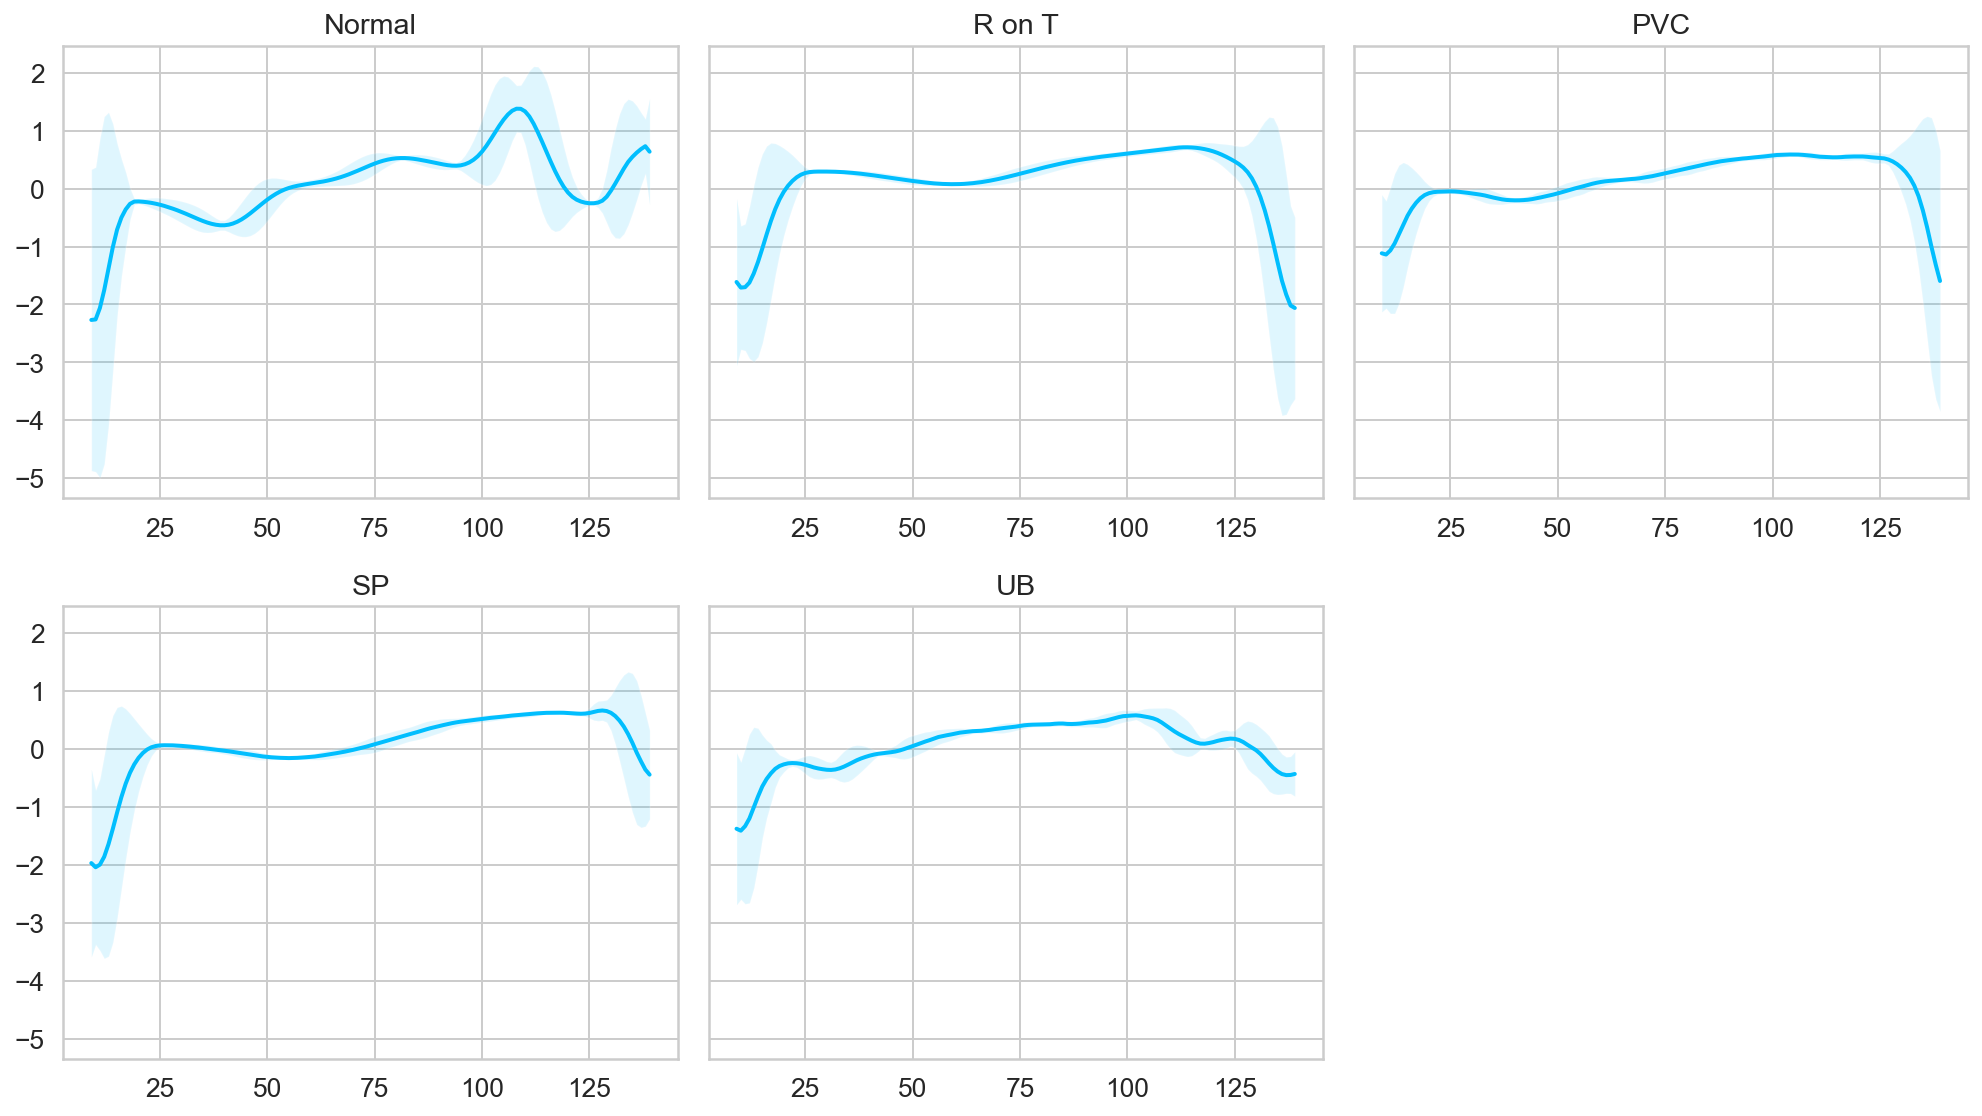

In [47]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls] \
        .drop(labels='target', axis=1) \
        .mean(axis=0) \
        .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

In [48]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [49]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [50]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [51]:
def create_dataset(df):

    sequences = df.astype(np.float32).to_numpy().tolist()

    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    n_seq, seq_len, n_features = torch.stack(dataset).shape

    return dataset, seq_len, n_features

In [52]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [54]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, hidden_dim = 50, latent_features=16):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.latent_features = latent_features
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Linear(
            in_features=self.hidden_dim,
            out_features=2*latent_features)

    def forward(self, x):
        x = x.reshape((-1, self.seq_len, self.n_features))

        x, (hidden_n, _) = self.lstm(x)
        x = self.fc(hidden_n)

        return x.view(-1, 2*self.latent_features)

In [55]:
class Decoder(nn.Module):

    def __init__(self, seq_len, n_features=1, hidden_dim=50, latent_features=16):
        super(Decoder, self).__init__()

        self.seq_len = seq_len
        self.hidden_dim, self.n_features = hidden_dim, n_features
        
        self.latent_to_hidden = nn.Linear(
            latent_features,
            hidden_dim
        )


        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=2 * seq_len,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        # (batch, 16) -> (batch, hidden)
        x = self.latent_to_hidden(x)
        
        # (batch, features, hidden)
        x = x.reshape(-1, n_features, self.hidden_dim)
        
        #(batch, features, hidden)
        x, (hidden_n, cell_n) = self.lstm(x)
        
        #(batch, features, 2*seq_len)
        return x.reshape(-1, 2*seq_len)

In [56]:
from torch import Tensor
from typing import Dict, Any, Tuple
from VAE.reparameterize import ReparameterizedDiagonalGaussian
from torch.distributions import Distribution


class BaseVAEprob(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, latent_features:int, encoder, decoder, beta=1) -> None:
        super(BaseVAEprob, self).__init__()
        
        self.latent_features = latent_features
        self.beta=beta

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = encoder
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        # mu, sigma        
        self.decoder = decoder
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        z_tmp = self.decoder(z)
        mu, log_sigma =  z_tmp.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}

    def elbo(self, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = self.forward(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = px.log_prob(x.view(-1, int(decoder.seq_len))).view(px.size0, -1).sum(dim=1)
        log_pz = pz.log_prob(z).view(pz.size0, -1).sum(dim=1)
        log_qz = qz.log_prob(z).view(qz.size0, -1).sum(dim=1)
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`

        kl = log_qz - log_pz
        elbo = log_px - kl
        beta_elbo = log_px - self.beta * kl
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs

In [57]:
encoder = Encoder(seq_len, n_features).to(device)
decoder = Decoder(seq_len)

In [58]:
model = BaseVAEprob(latent_features=16, encoder=encoder, decoder=decoder)

In [59]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [60]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [61]:
NUM_EPOCHS = 1000
LOSS_LIST = []
VAL_LOSS_LIST = []
for epoch in range(NUM_EPOCHS):
    running_loss = 0
    count = 0
    model.train()
    for batch in dat_loader:
        count += len(batch)/BATCH_SIZE
        batch = batch.to(device)

        loss, diagnostics, outputs = model.elbo(batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_loss_epoch = running_loss/count
    LOSS_LIST.append(avg_loss_epoch)
    
    with torch.no_grad():
        model.eval()
        
        # Just load a single batch from the test loader
        x = next(iter(validation_loader))
        x = x.to(device)
        val_loss, _, _ = model.elbo(x)
    
    VAL_LOSS_LIST.append(val_loss.item())
    
    print(f"epoch {epoch+1}")
    print(f"Average loss: {avg_loss_epoch}")
    print(f"Validation loss: {val_loss}")


epoch 1
Average loss: 182.76346994974304
Validation loss: 131.2100372314453
epoch 2
Average loss: 109.87258575328748
Validation loss: 99.73410034179688
epoch 3
Average loss: 95.69498678235843
Validation loss: 96.62708282470703
epoch 4
Average loss: 92.48780891021765
Validation loss: 85.77721405029297
epoch 5
Average loss: 91.18275022987203
Validation loss: 82.10806274414062
epoch 6
Average loss: 90.63144822526199
Validation loss: 91.36093139648438
epoch 7
Average loss: 90.04007330713422
Validation loss: 87.16205596923828
epoch 8
Average loss: 88.24991360118148
Validation loss: 82.57296752929688
epoch 9
Average loss: 86.28589073836154
Validation loss: 82.80833435058594
epoch 10
Average loss: 84.80110165381902
Validation loss: 81.57563781738281
epoch 11
Average loss: 84.69343790148882
Validation loss: 80.44752502441406
epoch 12
Average loss: 83.61616783649487
Validation loss: 83.13845825195312
epoch 13
Average loss: 83.90944754351824
Validation loss: 84.61581420898438
epoch 14
Average lo

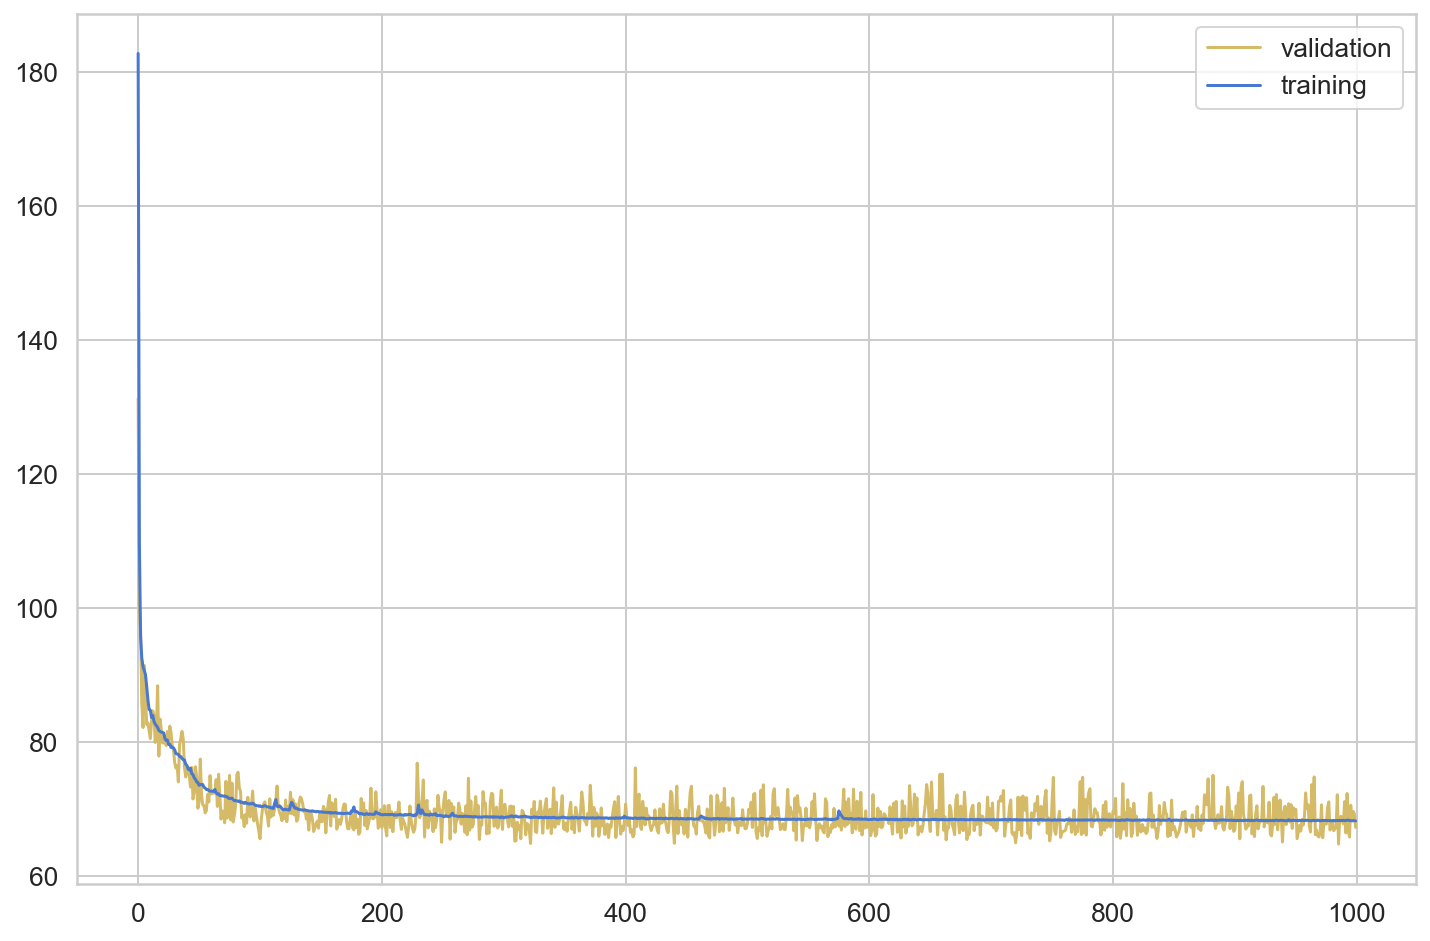

In [62]:
plt.plot(list(range(len(VAL_LOSS_LIST))), VAL_LOSS_LIST, c='y', label="validation")
plt.plot(list(range(len(LOSS_LIST))), LOSS_LIST, c='b', label="training")
plt.legend()
plt.show();

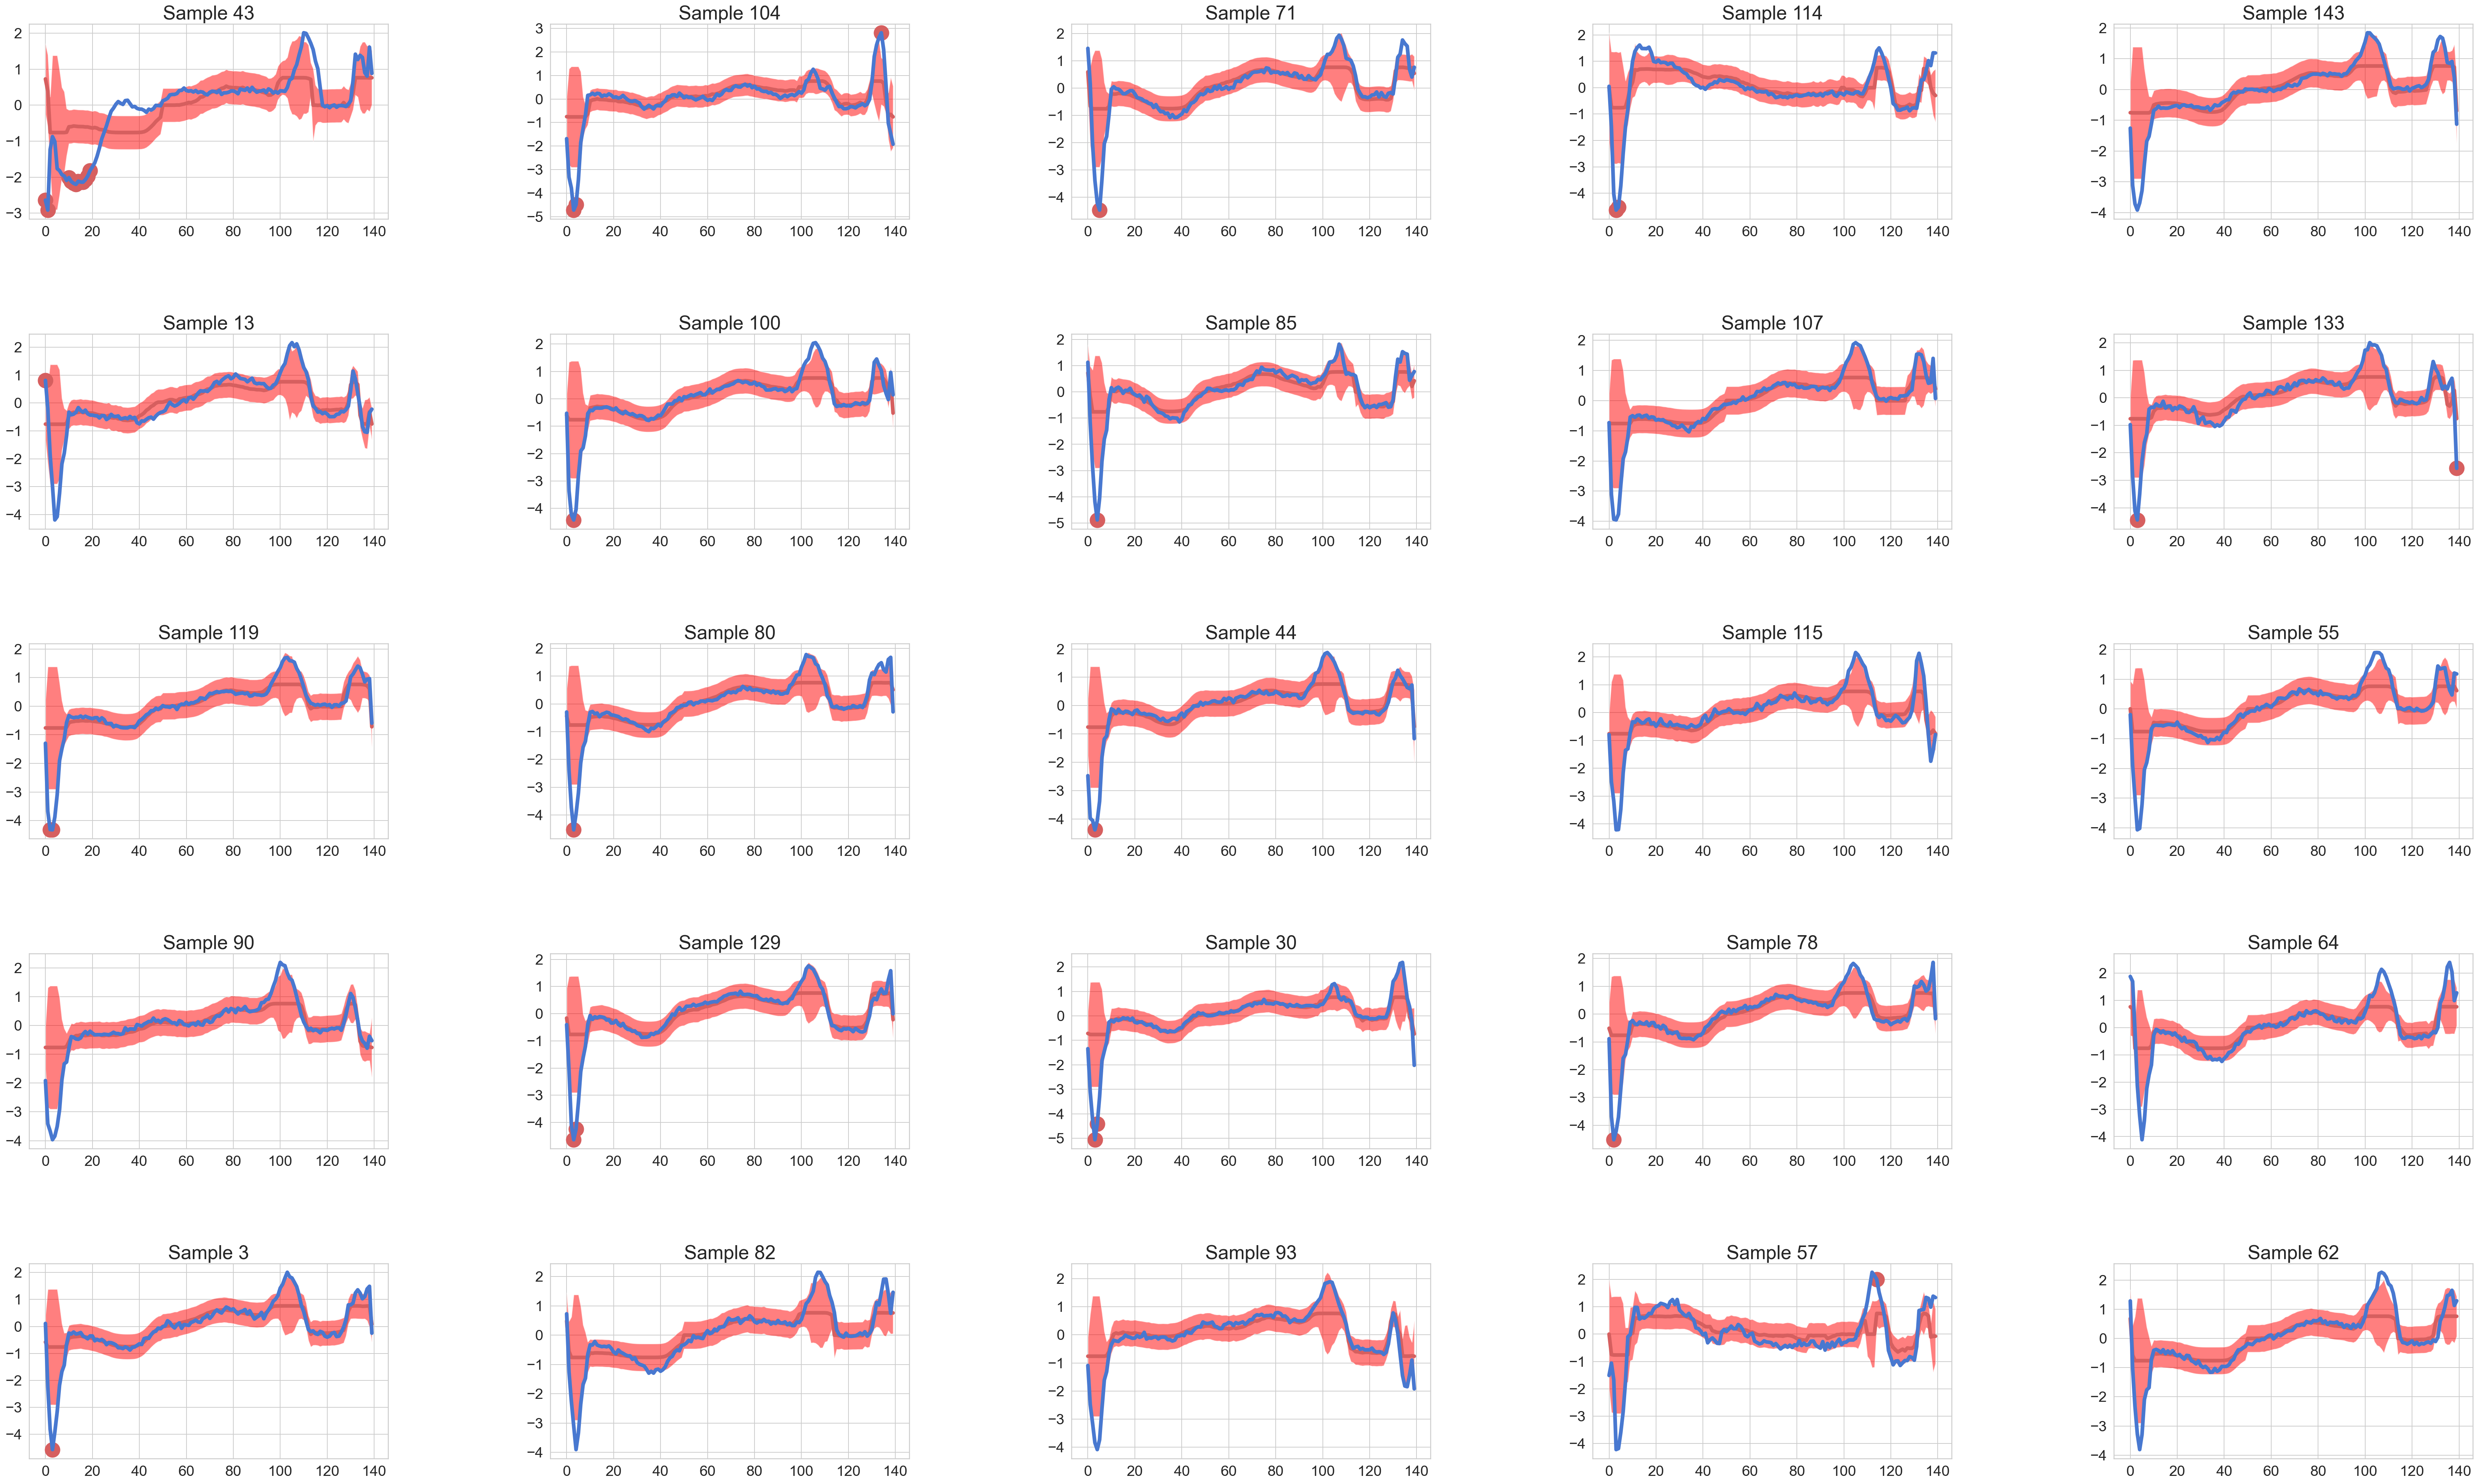

In [138]:
NUM_PLOTS = 25

samples = np.random.choice(len(test_normal_dataset), replace=False, size=NUM_PLOTS)
fig, axes = plt.subplots(nrows=int(np.sqrt(NUM_PLOTS)), ncols=int(np.sqrt(NUM_PLOTS)))
fig.tight_layout()
fig.set_size_inches(50, 30)
ANOMALY_THRESHOLD = 0.05
for i, ax in enumerate(axes.flat):
    outputs = model.forward(test_normal_dataset[i])
    log_probs = outputs["px"].log_prob(test_normal_dataset[i].view(-1)).exp().detach().numpy()
    idx = log_probs < ANOMALY_THRESHOLD
    anom = np.arange(len(test_normal_dataset[i]))[idx.squeeze()]
    
    mu = outputs["px"].mu.view(-1).detach().numpy()
    sigma = outputs["px"].sigma.view(-1).detach().numpy()
    ax.plot(mu, c="r", linewidth=5)
    ax.fill_between(list(range(len(mu))), mu-sigma, mu+sigma, facecolor='red', alpha=0.5)
    ax.plot(test_normal_dataset[i].view(-1), c="b", linewidth=5)
    ax.scatter(anom, test_normal_dataset[i].view(-1)[anom], c="r", s=400, label="anomaly")
    
    ax.set_title(f"Sample {samples[i]}", fontdict={"size": 26})
    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)
